<a href="https://colab.research.google.com/github/jonathanobise/applied-data-science-ibm/blob/master/The%20Battle%20of%20Neighbourhoods%20-%20Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Battle of the Neighbourhoods

## Introduction/Business Problem

A wealthy African family is planning on relocating to New York City. They desire to setup a grand african restaurant on arrival. They have tasked me with the responsibility of identifying the availability and spread of African restaurants in New York City, and to advise on the best market entry strategy. 

It is important to note that the demographics of New York City is one that is particularly and ethnically diverse, culturally rich and generally interesting. As one of the largest cities in the United States, it stands out on the strength of what it offers residents and visitors alike. With a population of just over 8 million people in 2017, it accounts for over 40% of the population of New York State and comes slightly behind the population percentage of the New York metropolitan area, which happens to be home to approximately 23.6 million people. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

New York City is also densely populated which as a result, it earned the term "melting pot" - coined to describe the densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

It is no brainer that with its diverse culture, comes the yearning for diverse food items and culinary tastes. There are many restaurants in New york City, belonging to different categories of ethnicities not limited to African, Chinese, French, Indian, etc. In addition to the task I mentioned earlier, my goal on this project is to highlight and visualize the neighbourhoods and boroughs in New York City where you can find African restaurants and the go-to-market strategy for entering the restaurant market for my client.


## Description of Data

Here is an overview of all the data points for this project:

A dataset of New York City containing the list Boroughs, Neighborhoods along with their latitude and longitude.
Data source : https://cocl.us/new_york_dataset
Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city.

A dataset leveraging Foursquare API of African resturants across the various neighborhood of NYC.
Data source : Fousquare API
Description : This API would prvide an up-to-date information on all the restaurants in each neighborhood. A further drill down of the dataset wil then provide the venues for African restaurants spread across the various neighbourhoods.

GeoSpace data
Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
Description : This will provide the functionality needed to visualize the New york Borough boundaries with the aid of a Choropleth map.

## The Approach Adopted

1. Collect the new york city data from https://cocl.us/new_york_dataset
2. Using FourSquare API we will find all venues for each neighborhood.
3. Filter out all venues that are African resturants.
4. Find rating , tips and like count for each African Resturants using FourSquare API.
5. Sort out the data using the ratings for each resturant.
6. Visualize the ranking of neighborhoods using folium library.

In [0]:
#Download and install geocoder and folium libraries
!pip install geocoder
!pip install folium

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Hey Buddy, Please confirm that all libraries have been imported.')

Hey Buddy, Please confirm that all libraries have been imported.


We then efine a function to get the geocodes(latitude and longitude) of a given location using geopy.

In [0]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Define a function to intract with FourSquare API and return the venue id, name and category. In addition to getting the top 100 venues within a radius of 1000 metres for a given latitude and longitude.

In [0]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'COV5ZNNCN1NVXMENKILEH1HQHJ0URDQR0RTHIR00SJD3IZ44' # your Foursquare ID
    CLIENT_SECRET = 'BM0KHR04QY4PEGBEH24FTHEGUR0PKV3OIDMWDE5RVHLTBYZS' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

We also get to define a function that will be used for ranking to get venue details sch as ratings and tip counts for a given venue id.

In [0]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'COV5ZNNCN1NVXMENKILEH1HQHJ0URDQR0RTHIR00SJD3IZ44' # your Foursquare ID
    CLIENT_SECRET = 'BM0KHR04QY4PEGBEH24FTHEGUR0PKV3OIDMWDE5RVHLTBYZS' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

We go further to define a funtion to get the New York City data showing the Boroughs and Neighborhoods along with their respective latitudes and longitudes.

In [0]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

The above function can be called to get the data from New York City.

In [0]:
# get new york data
new_york_data=get_new_york_data()

In [0]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [0]:
# lets find out the shape of out data set
new_york_data.shape

(306, 4)

This shows that there are 306 neighbourhoods in New York City

Lets plot a chart to visualize this dataset.

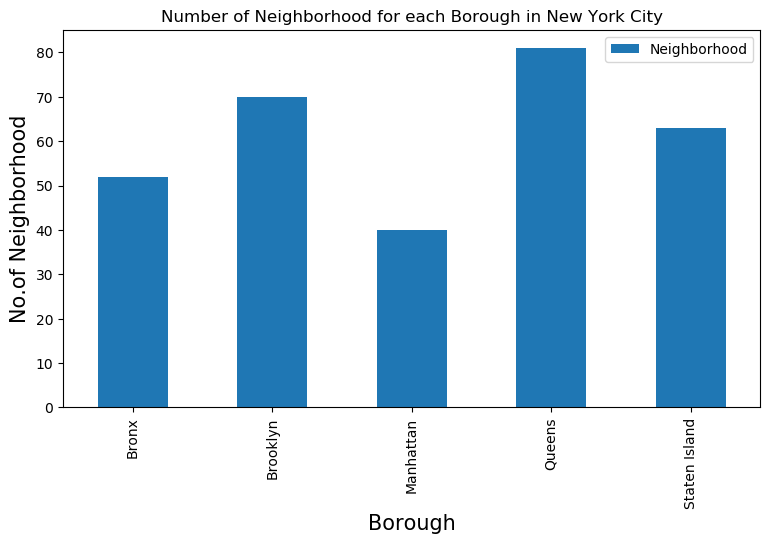

In [0]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

It is evident from our chart that Queens has go the highest number of neighborhoods compared to the others.

Lets narrow down to highlights the African resturants available in each of these neighbourhoods.

In [0]:
# prepare neighborhood list that contains african restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
african_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    african_resturants=venues[venues['Category']=='African Restaurant']   
    print('(',count,'/',len(new_york_data),')','African Resturants in '+Neighborhood+', '+Borough+':'+str(len(african_resturants)))
    for resturant_detail in african_resturants.values.tolist():
        id, name , category=resturant_detail
        african_rest_ny = african_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) African Resturants in Wakefield, Bronx:0
( 2 / 306 ) African Resturants in Co-op City, Bronx:0
( 3 / 306 ) African Resturants in Eastchester, Bronx:0
( 4 / 306 ) African Resturants in Fieldston, Bronx:0
( 5 / 306 ) African Resturants in Riverdale, Bronx:0
( 6 / 306 ) African Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) African Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) African Resturants in Woodlawn, Bronx:0
( 9 / 306 ) African Resturants in Norwood, Bronx:0
( 10 / 306 ) African Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) African Resturants in Baychester, Bronx:0
( 12 / 306 ) African Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) African Resturants in City Island, Bronx:0
( 14 / 306 ) African Resturants in Bedford Park, Bronx:0
( 15 / 306 ) African Resturants in University Heights, Bronx:2
( 16 / 306 ) African Resturants in Morris Heights, Bronx:0
( 17 / 306 ) African Resturants in Fordham, Bronx:1
( 18 / 306 ) African Resturants in East Tremont, Bronx:

In [0]:
african_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix


In [0]:
african_rest_ny.shape

(12, 4)

We got a paltry 12 African Resturants across New York City

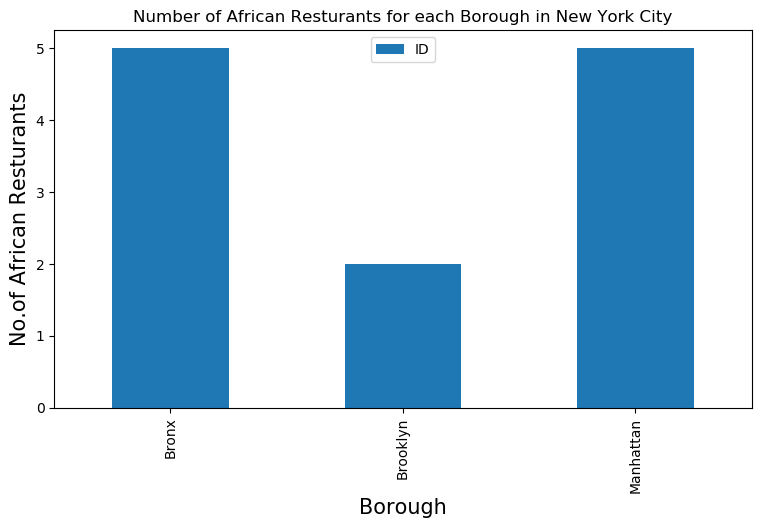

In [0]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of African Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of African Resturants', fontsize=15)
#giving a bar plot
african_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Bronx and Manhattan have the largest number of African resturants

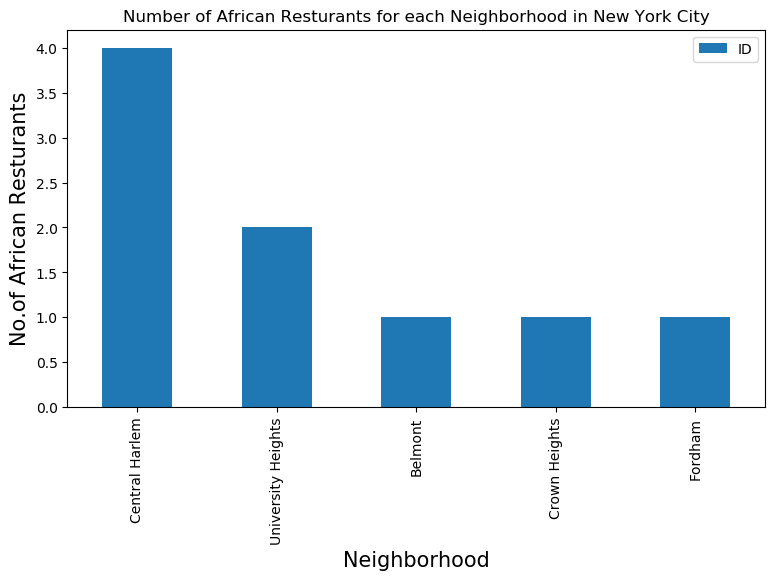

In [0]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of African Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of African Resturants', fontsize=15)
#giving a bar plot
african_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [0]:
african_rest_ny[african_rest_ny['Neighborhood']=='Central Harlem']

,Borough,Neighborhood,ID,Name
6,Manhattan,Central Harlem,53e01975498e78c0915599bf,Ponty Bistro Harlem
7,Manhattan,Central Harlem,4c2fdced452620a120551e0f,Keur Sokhna
8,Manhattan,Central Harlem,4a9ea132f964a520ad3a20e3,Africa Kine Restaurant
9,Manhattan,Central Harlem,5004a9e5e4b034c2950659fd,Les Ambassades Senegalais Bistro


So Central harlem and University Heights have got the highest number of African Resturants with a total count of 6.

Now we will get the ranking of each resturant for further analysis.

In [0]:
# prepare neighborhood list that contains african resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
african_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in african_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(african_rest_ny),')','processed')
    african_rest_stats_ny = african_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID             Name  Likes  Rating  Tips
0  4c2f8b1b7cc0c9b6a1eaeb9a  Accra Resturant      9     6.8     3
( 1 / 12 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.8     3
( 2 / 12 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.8     3
( 3 / 12 ) processed
                         ID               Name  Likes  Rating  Tips
0  4cb2beaadedbef3bca7c9d40  Papaye Restaurant     11     7.8     3
( 4 / 12 ) processed
                         ID          Name  Likes  Rating  Tips
0  51d4d2cc454a777ed5a76c57  Cafe Rue Dix    198     8.6    57
( 5 / 12 ) processed
                         ID                 Name  Likes  Rating  Tips
0  53e01975498e78c0915599bf  Ponty Bistro Harlem    101     8.6    29
( 6 / 12 ) processed
                         ID                 Name  Likes  Rating  Tip

In [0]:
african_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant,9,6.8,3
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix,198,8.6,57


In [0]:
african_rest_stats_ny.shape

(12, 7)

In [0]:
african_rest_ny.shape

(12, 4)

Now lets save our restaurant data to a csv sheet. This is to safeguard against modifying our hard work :) As per Foursquare API calls, we only have 500 premium calls per day to retrieve venue details. So, going forward, we will refer to the saved data sheet csv if required.

In [0]:
african_rest_stats_ny.to_csv('african_rest_stats_ny.csv', index=False)

To be sure nothing is broken, lets verify the data from our saved csv file.

In [0]:
african_rest_stats_ny_csv=pd.read_csv('african_rest_stats_ny.csv')

In [0]:
african_rest_stats_ny_csv.shape

(12, 7)

In [0]:
african_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,University Heights,4c2f8b1b7cc0c9b6a1eaeb9a,Accra Resturant,9,6.8,3
1,Bronx,University Heights,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
2,Bronx,Fordham,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
3,Bronx,Belmont,4cb2beaadedbef3bca7c9d40,Papaye Restaurant,11,7.8,3
4,Brooklyn,Crown Heights,51d4d2cc454a777ed5a76c57,Cafe Rue Dix,198,8.6,57


Evidently, we are good to go!

In [0]:
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
Borough         12 non-null object
Neighborhood    12 non-null object
ID              12 non-null object
Name            12 non-null object
Likes           12 non-null object
Rating          12 non-null float64
Tips            12 non-null object
dtypes: float64(1), object(6)
memory usage: 752.0+ bytes


In [0]:
african_rest_stats_ny['Likes']=african_rest_stats_ny['Likes'].astype('float64')

In [0]:
african_rest_stats_ny['Tips']=african_rest_stats_ny['Tips'].astype('float64')

In [0]:
african_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
Borough         12 non-null object
Neighborhood    12 non-null object
ID              12 non-null object
Name            12 non-null object
Likes           12 non-null float64
Rating          12 non-null float64
Tips            12 non-null float64
dtypes: float64(3), object(4)
memory usage: 752.0+ bytes


Now the data types looks good.

In [0]:
# Resturant with maximum Likes
african_rest_stats_ny.iloc[african_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                198
Rating                               8.6
Tips                                  57
Name: 4, dtype: object

In [0]:
# Resturant with maximum Rating
african_rest_stats_ny.iloc[african_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                198
Rating                               8.6
Tips                                  57
Name: 4, dtype: object

In [0]:
# Resturant with maximum Tips
african_rest_stats_ny.iloc[african_rest_stats_ny['Tips'].idxmax()]

Borough                         Brooklyn
Neighborhood               Crown Heights
ID              51d4d2cc454a777ed5a76c57
Name                        Cafe Rue Dix
Likes                                198
Rating                               8.6
Tips                                  57
Name: 4, dtype: object

In [0]:
ny_neighborhood_stats=african_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [0]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Neighborhood,Average Rating
2,Crown Heights,8.6
4,Hamilton Heights,8.6
0,Belmont,7.8
3,Fordham,7.8
1,Central Harlem,7.7


The above ratings are for the top neighbourhoods with the top average rating of African resturants

In [0]:
ny_borough_stats=african_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [0]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.88
1,Brooklyn,7.45
0,Bronx,7.40


Similarly these are the average ratings of African Resturants for each Borough.

Lets put some visuals to this data

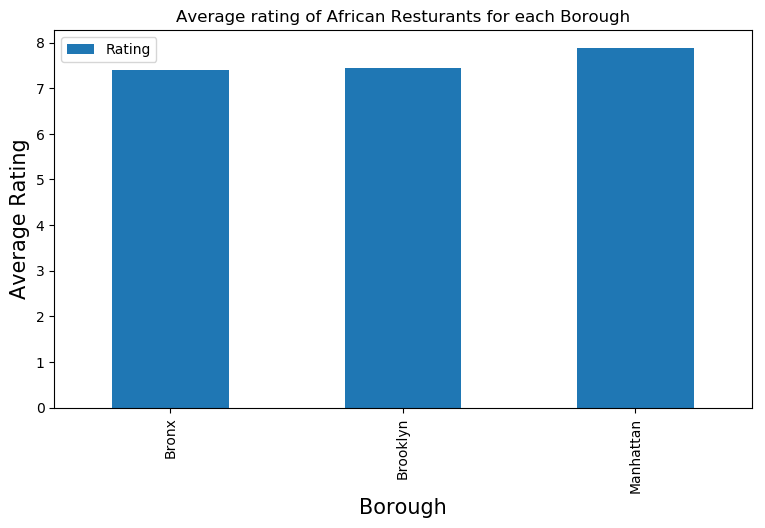

In [0]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of African Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
african_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 7.5 to visualize on map

In [0]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.5]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Belmont,7.8
1,Central Harlem,7.7
2,Crown Heights,8.6
3,Fordham,7.8
4,Hamilton Heights,8.6


We will join this dataset to original new york data to get lonitude and latitude

In [0]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Belmont,40.857277,-73.888452,7.8
1,Manhattan,Central Harlem,40.815976,-73.943211,7.7
2,Brooklyn,Crown Heights,40.670829,-73.943291,8.6
3,Bronx,Fordham,40.860997,-73.896427,7.8
4,Manhattan,Hamilton Heights,40.823604,-73.949688,8.6


Now we will show this data on a map

In [0]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [0]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighbourhoods. 

Lets Visualize Boroughs based on average rating.

In [0]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
#ny_geo = r'Borough_Boundaries.geojson'
ny_geo = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=GeoJSON'

#ny_map.choropleth(
folium.Choropleth(
    geo_data=ny_geo,
    name='choropleth',
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

ny_map
# display map
# as this is huge map data , we will save it to a file
#ny_map.save('borough_rating.html')

## Results Discussion and Limitations

From the analysis, out of the 306 neighbourhoods in New York City, only 12 African restaurants are spread across the city. This is surprising considering the sheer number of Africans living in New York City. This paltry number is a far cry from the number of restaurants owned and run by other ethnic nationalities like the Chinese, Indians, etc., Restaurants in Crown heights have the highest number of ratings. While Manhattan takes the lead for the Boroughs. However, it is very important to note that this result is solely based on the data pulled from the Foursquare API..


## Observations

For the Boroughs, Manhattan has the highest number of African restaurants. This is closely followed by Bronx and Brooklyn. This makes it just 3 out of the 5 Boroughs housing African restaurants.


## Conclusion

The opportunity exists to set up an African restaurant and scale it all the same. The market for African cuisine is available but the supply is below demand. In addition to this, the competition is not not stiff as you would have in other sectors. Thus, starting an African restaurant business is a step in the right direction.
